# DML Group Project on DETR

In this notebook, we are going to fine-tune and improve [DETR](https://huggingface.co/docs/transformers/model_doc/detr) (end-to-end object detection with Transformers) on a custom object detection dataset. The goal for the model is to detect objects in a custom dataset.

Our framework is based  on this tutorial: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb. Thanks to NielsRogge, the tutorials' creator.

We're going to fine-tune the model using [PyTorch Lightning].


## Create Dataset & Dataloaders

Torchvision already provides a `CocoDetection` dataset, which we can use. NielsRogge only add an image processor (`DetrImageProcessor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [1]:
import os
import torch
import torchvision
from transformers import DetrImageProcessor

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "annotations.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target 
        # converting target to DETR format, resizing + normalization of both image and target
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return pixel_values, target

DATA_DIR = './/shipdata'  # to modify

TRAIN_DIR = os.path.join(DATA_DIR, "train")  # Train Data
VAL_DIR = os.path.join(DATA_DIR, "val")  # Validation Data
# TEST_DIR = os.path.join(DATA_DIR, "test")  # Test Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=TRAIN_DIR, processor=processor)
val_dataset = CocoDetection(img_folder=VAL_DIR, processor=processor, train=False)
# test_dataset = CocoDetection(img_folder=TEST_DIR, processor=processor, train=False)

2023-10-22 02:01:25.675127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 02:01:25.675187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 02:01:25.675225: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 02:01:25.685151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The `max_size` parameter is deprecated and

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


As you can see, this dataset is tiny. At the beginning, we use a train dataset of 5k images, then each epoch takes about 2 hours. To reduce the time costs of the project, we cut the train dataset to 1.5k images.

In [2]:
print("Number of Training examples:", len(train_dataset))
print("Number of Val           examples:", len(val_dataset))
# print("Number of Test         examples:", len(test_dataset))

Number of Training examples: 1536
Number of Val           examples: 226


Show an example by visualizing it. We can access the COCO API of the dataset by typing `train_dataset.coco`. 

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

cats = val_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

def display_truth(image_id = None):
    image_ids = val_dataset.coco.getImgIds()
    image_id = image_ids[np.random.randint(0, len(image_ids))] if image_id == None else image_id
    print('Image #{} Ground True Objects: '.format(image_id))

    image = val_dataset.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join(VAL_DIR, image['file_name']))

    annotations = val_dataset.coco.imgToAnns[image_id]
    draw = ImageDraw.Draw(image, "RGBA")



    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()

    for annotation in annotations:
        box = annotation['bbox']
        class_idx = annotation['category_id']
        x,y,w,h = tuple(box)

        ax.add_patch(plt.Rectangle((x, y), w, h,
                                   fill=False, color='yellow', linewidth=3))
        text = f'{id2label[class_idx]}'
        ax.text(x, y - 10, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

There are large boats as well as very small boat objects in the image:

Image #0 Ground True Objects: 


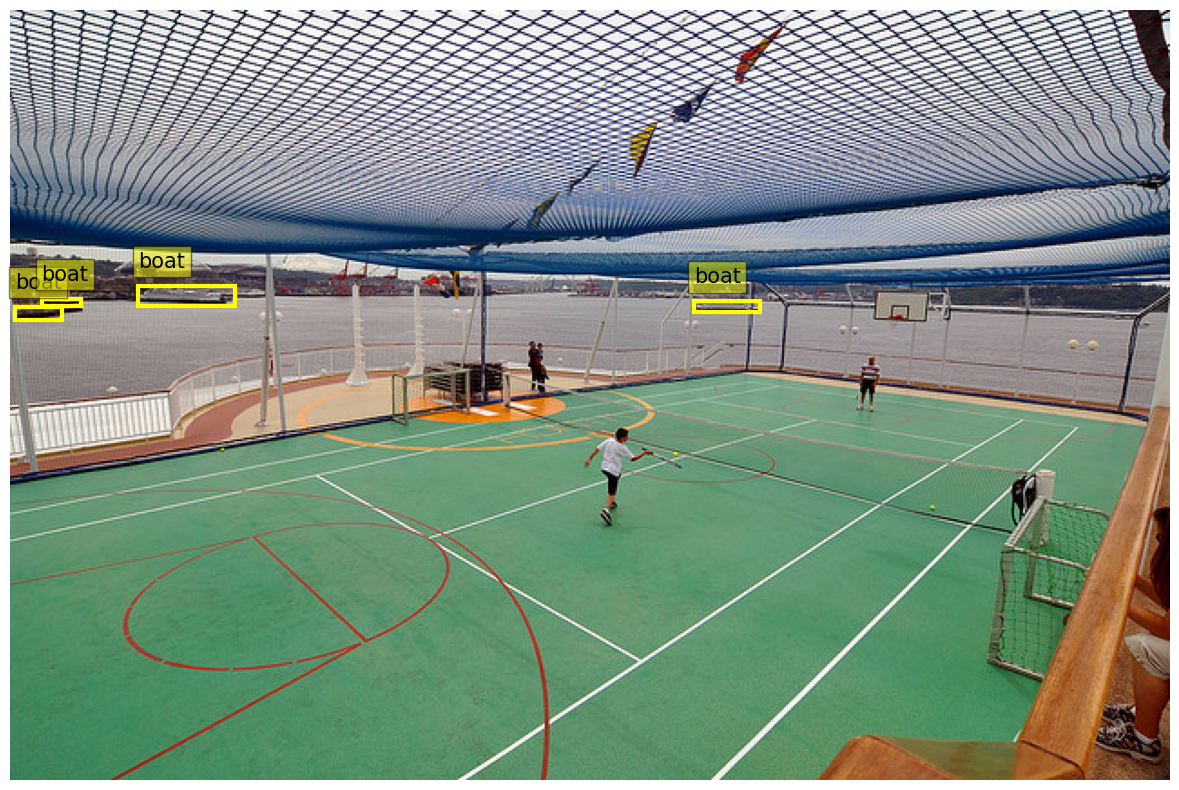

In [4]:
display_truth(0)

Next, let's create corresponding PyTorch dataloaders, which allow us to get batches of data. We define a custom `collate_fn` to batch images together. As DETR resizes images to have a min size of 800 and a max size of 1333, images can have different sizes. We pad images (`pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask` to indicate which pixels are real (1)/which are padding (0).  

In [5]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch

train_batch_size = 4  # batch size for training
val_batch_size = 4  # batch size for validation

train_dataloader = DataLoader(train_dataset,
                              collate_fn=collate_fn,
                              batch_size=train_batch_size,
                              shuffle=True,
                              num_workers=6
                             )
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=val_batch_size, num_workers=6)
batch = next(iter(train_dataloader))

## Train

Train the model using PyTorch Lightning. Here we define a `LightningModule`, which is an `nn.Module` with some extra functionality.

As PyTorch Lightning by default logs to **Tensorboard**, we can open the board and see log data on a local browser.

In [6]:
%load_ext tensorboard
# %tensorboard --logdir ./logs/lightning_logs/

In [7]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection

class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        
        # we specify the "no_timm" variant here to not rely on the timm library for the convolutional backbone
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm", 
                                                             num_labels=len(id2label),   # replace COCO classification head with a custom classifer based on this dataset
                                                             ignore_mismatched_sizes=True)
       
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay
        self.val_outs = []  # for evaluation

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        return outputs
     
    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return outputs, loss, loss_dict

    def training_step(self, batch, batch_idx):
        _, loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())
        
        return loss

    def validation_step(self, batch, batch_idx):
        outputs, loss, loss_dict = self.common_step(batch, batch_idx)
        labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized
        self.val_outs.append((labels, outputs))  # for evaluation
#         print(self.current_epoch, "validation_loss: ", loss)
        self.log("validation_loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

Here we define the model, and verify the outputs.

In [8]:
myModel = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
outputs = myModel(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

# freeze backbone and transformer
for name, param in myModel.named_parameters():
    if 'model.model' in name:
        param.requires_grad = False
    print(name, param.requires_grad, param.shape)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.model.backbone.conv_encoder.model.embedder.embedder.convolution.weight False torch.Size([64, 3, 7, 7])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.0.shortcut.convolution.weight False torch.Size([256, 64, 1, 1])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.0.convolution.weight False torch.Size([64, 64, 1, 1])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.1.convolution.weight False torch.Size([64, 64, 3, 3])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.0.layer.2.convolution.weight False torch.Size([256, 64, 1, 1])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.0.convolution.weight False torch.Size([64, 256, 1, 1])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.1.convolution.weight False torch.Size([64, 64, 3, 3])
model.model.backbone.conv_encoder.model.encoder.stages.0.layers.1.layer.2.convolution.weight False torch.Size([256, 64, 1, 1])
mode

The logits are of shape `(batch_size, num_queries, number of classes + 1)`. We model internally adds an additional "no object class", which explains why we have one additional output for the class dimension. 

In [9]:
print(outputs.logits.shape)
print(outputs.keys())

torch.Size([4, 100, 2])
odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


Defines some callback functions to store the training process and results:

In [10]:
## Callback for saving local checkpoints
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    verbose=True,
    every_n_train_steps = 50,
    dirpath="./checkpoints",
#     filename="checkpoint-{epoch}-{step}",
    filename="last"
)

# Callback for  pushing to Hugging Face
class PushToHubCallback(pl.Callback):
    '''
    Callback for  pushing to Hugging Face
    '''
    def __init__(self, model_name):
        self.name = model_name
    
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model {self.name} to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("cheaple/my-detr",
                                    commit_message=f"{self.name} training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model {self.name} to the hub after training")
        pl_module.processor.push_to_hub("cheaple/my-detr",
                                    commit_message=f"{self.name} training done")
        pl_module.model.push_to_hub("cheaple/my-detr",
                                    commit_message=f"{self.name} training done")

#### Callback for evaluation during training

To run the evaluation, we must make sure that the outputs of the model are in the format that the metric expects. For that we need to turn the boxes which are in (x1, y1, x2, y2) format into (x, y, width, height), and turn the predictions into a list of dictionaries:

In [11]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

def prepare_for_coco_detection(predictions):
    def convert_to_xywh(boxes):
        xmin, ymin, xmax, ymax = boxes.unbind(1)
        return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results


class EvaluatorCallback(pl.Callback):
    '''
    Callback for evaluation during training
    '''
    def on_validation_epoch_end(self, trainer, pl_module):
        evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])
        
        print("Running evaluation...")
        for _, (labels, outputs) in enumerate(tqdm(pl_module.val_outs)):
            # turn into a list of dictionaries (one item for each example in the batch)
            orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
            results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

            # provide to metric
            # metric expects a list of dictionaries, each item 
            # containing image_id, category_id, bbox and score keys 
            predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
            predictions = prepare_for_coco_detection(predictions)
            evaluator.update(predictions)
        evaluator.synchronize_between_processes()
        evaluator.accumulate()
        evaluator.summarize()
        
        keys = ['AP', 'AP50','AP75','APs','APm','APl', 'AR1', 'AR10','AR100','ARs','ARm','ARl']
            
        results = {k: stat for k, stat in zip(keys, evaluator.coco_eval['bbox'].stats)}
#         print(trainer.current_epoch, "evaluation:\n ", results)
        self.log_dict(results)
        
        del pl_module.val_outs[:]
        pl_module.val_outs = []  # clear validation outputs

In [12]:
def run_train(model, num_epochs, callbacks, checkpoint):
    trainer = pl.Trainer(
        callbacks=callbacks,
        num_sanity_val_steps=0,
        max_epochs=num_epochs,
        gradient_clip_val=0.1,
        default_root_dir="."
    )
    trainer.fit(model,
               ckpt_path = checkpoint
               )

Start training. You can refresh Tensorboard above to check the various losses.

In [13]:
run_train(myModel, 
          num_epochs=20,
          callbacks=[checkpoint_callback, PushToHubCallback("Classic DETR"), EvaluatorCallback()],
          checkpoint=None,
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/student/DETR/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
133 K     Trainable params
41.4 M    Non-trainable params
41.5 M    Total params
166.007   Total estimated model params size (MB)


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Running evaluation...


/home/student/conda/envs/detr/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.486
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.580
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.575
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.576
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.538
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.589
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.648
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.424
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.389
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.396
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.176
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.477
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.207
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.625
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.409
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.557
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.592
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.634
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.424
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.271
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.631
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.603
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.530
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.649
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.558
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.416
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.613
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.401
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.649
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.625
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.611
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.409
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Validation: |                                                                                     | 0/? [00:00…

Running evaluation...


  0%|          | 0/57 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.648
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.622
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.186
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Pushing model Classic DETR to the hub after training


AttributeError: 'Detr' object has no attribute 'processor'

## Push to Hugging Face

During training, the model will be pushed to Hugging Face automatically. Sometimes we might need to push manually.

In [ ]:
myModel.model.push_to_hub("cheaple/my-detr")
# processor.push_to_hub("cheaple/my-detr")

We can easily reload the model, and move it to the GPU as follows:

## Reload Models From Hugging Face

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained DETR
pretrained_detr = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm", 
#                                                              num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
pretrained_detr.to(device)

# Load my trained DETR
my_detr = DetrForObjectDetection.from_pretrained("cheaple/my-detr", 
                                                 id2label=id2label, 
                                                 revision="bc1f1d70fa253aed0dd9e0977ced1d6d35a4d71c")
my_detr.to(device)

## Evaluate the model

Finally, we evaluate the model on the validation set. For this we make use of the `CocoEvaluator` class available in a [tiny PyPi package](https://github.com/NielsRogge/coco-eval) I made. This class is entirely based on the original evaluator class used by the DETR authors.

Let's run the evaluation:

In [ ]:
def evaluate(model, val_dataset, val_dataloader):
    # initialize evaluator with ground truth (gt)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    myModel.model.to(device)
    evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

    print("Running evaluation...")
    for idx, batch in enumerate(tqdm(val_dataloader)):
        # get the inputs
        pixel_values = batch["pixel_values"].to(device)
        pixel_mask = batch["pixel_mask"].to(device)
        labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

        # forward pass
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)  # our model

        # turn into a list of dictionaries (one item for each example in the batch)
        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

        # provide to metric
        # metric expects a list of dictionaries, each item 
        # containing image_id, category_id, bbox and score keys 
        predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
        predictions = prepare_for_coco_detection(predictions)
        evaluator.update(predictions)

        evaluator.synchronize_between_processes()
        evaluator.accumulate()
        evaluator.summarize()

In [ ]:
# the original DETR has a different id-label mapping that is based on COCO, 
# so it uses a different version of val dataset.
VAL_DIR = os.path.join('.//shipdata_v1.0', "val")
val_dataset_coco = CocoDetection(img_folder=VAL_DIR, processor=processor, train=False)
val_dataloader_coco = DataLoader(val_dataset_coco,
                                 collate_fn=collate_fn,
                                 batch_size=val_batch_size,
                                 num_workers=1
                                )
evaluate(pretrained_detr, val_dataset_coco, val_dataset_coco)

In [ ]:
evaluate(my_detr, val_dataset, val_dataset)

## Inference

Visualize the predictions of DETR on a random image of the validation set.

In [ ]:
# id - label mapping for the original COCO dataset
import json
id2label_strings = '{"1": "person", "2": "bicycle", "3": "car", "4": "motorcycle", "5": "airplane", "6": "bus", "7": "train", "8": "truck", "9": "boat", "10": "traffic light", "11": "fire hydrant", "13": "stop sign", "14": "parking meter", "15": "bench", "16": "bird", "17": "cat", "18": "dog", "19": "horse", "20": "sheep", "21": "cow", "22": "elephant", "23": "bear", "24": "zebra", "25": "giraffe", "27": "backpack", "28": "umbrella", "31": "handbag", "32": "tie", "33": "suitcase", "34": "frisbee", "35": "skis", "36": "snowboard", "37": "sports ball", "38": "kite", "39": "baseball bat", "40": "baseball glove", "41": "skateboard", "42": "surfboard", "43": "tennis racket", "44": "bottle", "46": "wine glass", "47": "cup", "48": "fork", "49": "knife", "50": "spoon", "51": "bowl", "52": "banana", "53": "apple", "54": "sandwich", "55": "orange", "56": "broccoli", "57": "carrot", "58": "hot dog", "59": "pizza", "60": "donut", "61": "cake", "62": "chair", "63": "couch", "64": "potted plant", "65": "bed", "67": "dining table", "70": "toilet", "72": "tv", "73": "laptop", "74": "mouse", "75": "remote", "76": "keyboard", "77": "cell phone", "78": "microwave", "79": "oven", "80": "toaster", "81": "sink", "82": "refrigerator", "84": "book", "85": "clock", "86": "vase", "87": "scissors", "88": "teddy bear", "89": "hair drier", "90": "toothbrush"}'
id2label_coco = {int(k): v for k, v in json.loads(id2label_strings).items()}

Load each models:

In [ ]:
def display_inference(model, id_label_mapping, image_id = None):
    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
              [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    def plot_results(pil_img, scores, labels, boxes):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        for score, label_id, (xmin, ymin, xmax, ymax),c  in zip(scores, 
                                                             labels, 
                                                             boxes, 
                                                             colors
                                                            ):
            if id_label_mapping[label_id] != 'boat':
                continue  # skip other objects
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=3))
            text = f'{id_label_mapping[label_id]}: {score:0.2f}'
            ax.text(xmin, ymin - 10, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        plt.axis('off')
        plt.show()
        
    # Load image
    image_id = random.choice(image_ids) if image_id == None else image_id
    print('Image #{} Detected Objects: '.format(image_id))
    image = val_dataset.coco.loadImgs(image_id)[0]
    image_path = os.path.join(val_dataset.root, image['file_name'])
    image = Image.open(image_path)
    
    # Detections
    pixel_values, target = val_dataset[image_id]
    pixel_values = pixel_values.unsqueeze(0).to(device)
    with torch.no_grad():
      # forward pass to get class logits and bounding boxes
      outputs = model(pixel_values=pixel_values, pixel_mask=None)
    width, height = image.size
    results = processor.post_process_object_detection(outputs,
                                                      target_sizes=[(height, width)],
                                                      threshold=0.7
                                                     )[0]
    plot_results(image, results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist())

In [ ]:
display_truth(0)

In [ ]:
display_inference(pretrained_detr, id2label_coco, 0)

In [ ]:
display_inference(my_detr, id2label, 0)